 # Kqlmagic  - __parametrization__ features
***
Explains how to emebed python values in kql queries
***
***



## Make sure that you have the lastest version of  Kqlmagic
Download Kqlmagic from PyPI and install/update
(if latest version ims already installed you can skip this step)

In [1]:
#!pip install Kqlmagic --no-cache-dir --upgrade

## Add Kqlmagic to notebook magics

>>> kernel_location from parent: local



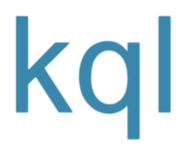

>>> _set_temp_files_server
>>> _set_temp_files_server
>>> startServer
>>> command: C:\Users\michabin\AppData\Local\Continuum\anaconda3\envs\lab-py36\python.exe C:\MyProjects\KqlmagicAtMicrosoftGithub\jupyter-Kqlmagic\azure\Kqlmagic\my_files_server.py -protocol=http -host=127.0.0.1 -port=57351 -base_folder="C:\MyProjects\KqlmagicAtMicrosoftGithub\jupyter-Kqlmagic\notebooks" -folders="Kqlmagic_temp_files/b80c18ab-4b9d-473b-8e50-c58fd249655a" -parent_id="24876" -clean="folders"
>>> _set_temp_files_server count: 0
>>> _set_temp_files_server server_url: http://127.0.0.1:57351
>>> mode: button
>>> close_window_timeout_in_secs: -1
>>> file_path: http://127.0.0.1:57351/files/Kqlmagic_temp_files/b80c18ab-4b9d-473b-8e50-c58fd249655a/what_new_history.html?kernelid=b80c18ab-4b9d-473b-8e50-c58fd249655a. window_name: what_new_history
>>> html_str: <!DOCTYPE html>
            <html><body>
            <div style='padding: 10px; color: #3a87ad; background-color: #d9edf7; border-color: #bce9f1'>
       

In [2]:
%reload_ext Kqlmagic

## Authenticate to get access to data

In [3]:
%kql azure-data-explorer://code;cluster='help';database='Samples'

>>> _set_temp_files_server
>>> nteract, temp_files_server_address: http://127.0.0.1:57351, kernel_location=local
>>> nteract -  popup_interaction
>>> device_code_login_notification: popup_interaction
>>> mode: button
>>> close_window_timeout_in_secs: -1
>>> file_path: http://127.0.0.1:57351/webbrowser?url=https%3A//microsoft.com/devicelogin&kernelid=b80c18ab-4b9d-473b-8e50-c58fd249655a. window_name: verification_url
>>> html_str: <!DOCTYPE html>
            <html><body>
            <div style=''>
            <b>DR5KHH4JN</b>
            <button onclick="this.style.visibility='hidden';
            kql_MagicLaunchWindowFunction('http://127.0.0.1:57351/webbrowser?url=https%3A//microsoft.com/devicelogin&kernelid=b80c18ab-4b9d-473b-8e50-c58fd249655a', 'fullscreen=no,directories=no,location=no,menubar=no,resizable=yes,scrollbars=yes,status=no,titlebar=no,toolbar=no,', 'verification_url', '');
            kql_MagicCloseWindow(kql_Magic_verification_url, -1, -1);">
            Copy code to cli

>>> mode: button
>>> close_window_timeout_in_secs: -1
>>> file_path: http://127.0.0.1:57351/files/Kqlmagic_temp_files/b80c18ab-4b9d-473b-8e50-c58fd249655a/_Samples_at_help_schema.html?kernelid=b80c18ab-4b9d-473b-8e50-c58fd249655a. window_name: _Samples_at_help_schema
>>> html_str: <!DOCTYPE html>
            <html><body>
            <div style=''>
            
            <button onclick="this.style.visibility='visible';
            kql_MagicLaunchWindowFunction('http://127.0.0.1:57351/files/Kqlmagic_temp_files/b80c18ab-4b9d-473b-8e50-c58fd249655a/_Samples_at_help_schema.html?kernelid=b80c18ab-4b9d-473b-8e50-c58fd249655a', 'fullscreen=no,directories=no,location=no,menubar=no,resizable=yes,scrollbars=yes,status=no,titlebar=no,toolbar=no,', '_Samples_at_help_schema', '');
            kql_MagicCloseWindow(kql_Magic__Samples_at_help_schema, -1, -1);">
            popup schema Samples@help</button>
            </div>

            <script>
            var kql_Magic__Samples_at_help_schema = 

## Use python user namespace as source of parameters
- prefix query with **kql let statements** to parametrize the query
- beware to the mapping: 
 - int -> long 
 - float -> real
 - str -> string
 - bool -> bool
 - datetime -> datetime
 - timedelta -> timespan
 - dict, list, set, tuple -> dynamic   (only if can be serialized to json)
 - **pandas dataframe -> view table**
 - None -> null
 - unknown, str(value) == 'nan' -> real(null)
 - unknown, str(value) == 'NaT' -> datetime(null)
 - unknown str(value) == 'nat' -> time(null)
 - other -> string

In [4]:
from datetime import datetime, timedelta
my_limit = 10
my_not_state = 'TEXAS'
my_start_datetime = datetime(2007, 8, 29)
my_timespan = timedelta(days=100)
my_dict = {"a":1}
my_list = ["x", "y", "z"]
my_tuple = ("t", 44, my_limit)
my_set = {6,7,8}

In [5]:
%%kql 
    let _dict_ = my_dict;
    let _list_ = my_list;
    let _tuple_ = my_tuple;
    let _set_ = my_set;
    let _start_time_ = my_start_datetime;
    let _timespan_ = my_timespan;
    let _limit_ = my_limit;
    let _not_val_ = my_not_state;
    StormEvents
    | where StartTime >= _start_time_
    | where EndTime <= _start_time_ + _timespan_
    | where State != _not_val_
    | summarize count() by State
    | extend d = _dict_
    | extend l = _list_
    | extend t = _tuple_
    | extend s = _set_
    | sort by count_ 
    | limit _limit_

>>> _set_temp_files_server


State,count_,d,l,t,s
GEORGIA,413,{'a': 1},"['x', 'y', 'z']","['t', 44, 10]","[8, 6, 7]"
MICHIGAN,357,{'a': 1},"['x', 'y', 'z']","['t', 44, 10]","[8, 6, 7]"
KANSAS,335,{'a': 1},"['x', 'y', 'z']","['t', 44, 10]","[8, 6, 7]"
MINNESOTA,316,{'a': 1},"['x', 'y', 'z']","['t', 44, 10]","[8, 6, 7]"
IOWA,311,{'a': 1},"['x', 'y', 'z']","['t', 44, 10]","[8, 6, 7]"
CALIFORNIA,303,{'a': 1},"['x', 'y', 'z']","['t', 44, 10]","[8, 6, 7]"
WISCONSIN,299,{'a': 1},"['x', 'y', 'z']","['t', 44, 10]","[8, 6, 7]"
MISSOURI,290,{'a': 1},"['x', 'y', 'z']","['t', 44, 10]","[8, 6, 7]"
ILLINOIS,274,{'a': 1},"['x', 'y', 'z']","['t', 44, 10]","[8, 6, 7]"
TENNESSEE,256,{'a': 1},"['x', 'y', 'z']","['t', 44, 10]","[8, 6, 7]"


[{'State': 'GEORGIA', 'count_': 413, 'd': {'a': 1}, 'l': ['x', 'y', 'z'], 't': ['t', 44, 10], 's': [8, 6, 7]},
 {'State': 'MICHIGAN', 'count_': 357, 'd': {'a': 1}, 'l': ['x', 'y', 'z'], 't': ['t', 44, 10], 's': [8, 6, 7]},
 {'State': 'KANSAS', 'count_': 335, 'd': {'a': 1}, 'l': ['x', 'y', 'z'], 't': ['t', 44, 10], 's': [8, 6, 7]},
 {'State': 'MINNESOTA', 'count_': 316, 'd': {'a': 1}, 'l': ['x', 'y', 'z'], 't': ['t', 44, 10], 's': [8, 6, 7]},
 {'State': 'IOWA', 'count_': 311, 'd': {'a': 1}, 'l': ['x', 'y', 'z'], 't': ['t', 44, 10], 's': [8, 6, 7]},
 {'State': 'CALIFORNIA', 'count_': 303, 'd': {'a': 1}, 'l': ['x', 'y', 'z'], 't': ['t', 44, 10], 's': [8, 6, 7]},
 {'State': 'WISCONSIN', 'count_': 299, 'd': {'a': 1}, 'l': ['x', 'y', 'z'], 't': ['t', 44, 10], 's': [8, 6, 7]},
 {'State': 'MISSOURI', 'count_': 290, 'd': {'a': 1}, 'l': ['x', 'y', 'z'], 't': ['t', 44, 10], 's': [8, 6, 7]},
 {'State': 'ILLINOIS', 'count_': 274, 'd': {'a': 1}, 'l': ['x', 'y', 'z'], 't': ['t', 44, 10], 's': [8, 6, 7]},
 {'State': 'TENNESSEE', 'count_': 256, 'd': {'a': 1}, 'l': ['x', 'y', 'z'], 't': ['t', 44, 10], 's': [8, 6, 7]}]

## Dataframe prameter as a kql table
- prefix query with **kql let statement** that assigns a kql var to the dataframe
- beware to the mapping of the dataframe to kql table columns types : 
 - int8,int16,int32,int64,uint8,uint16,uint32,uint64  -> long 
 - float16,float32,float64 -> real
 - character -> string
 - bytes -> string
 - void -> string
 - category -> string
 - datetime,datetime64,datetime64[ns],datetime64[ns,tz] -> datetime
 - timedelta,timedelta64,timedelta64[ns] -> timespan
 - bool -> bool
 - record -> dynamic
 - complex64,complex128 -> dynamic([real, imag])
 - object -> if all objects of type:
   - dict,list,tuple,set -> dynamic (only if can be serialized to json)
   - bool or nan -> bool
   - float or nan -> float
   - int or nan -> long
   - datetime or 'NaT' -> datetime
   - timedeltae or 'NaT' -> timespan
   - other -> string

In [6]:
my_df =_kql_raw_result_.to_dataframe()

In [7]:
my_df

,State,count_,d,l,t,s
0,GEORGIA,413,{'a': 1},"[x, y, z]","[t, 44, 10]","[8, 6, 7]"
1,MICHIGAN,357,{'a': 1},"[x, y, z]","[t, 44, 10]","[8, 6, 7]"
2,KANSAS,335,{'a': 1},"[x, y, z]","[t, 44, 10]","[8, 6, 7]"
3,MINNESOTA,316,{'a': 1},"[x, y, z]","[t, 44, 10]","[8, 6, 7]"
4,IOWA,311,{'a': 1},"[x, y, z]","[t, 44, 10]","[8, 6, 7]"
5,CALIFORNIA,303,{'a': 1},"[x, y, z]","[t, 44, 10]","[8, 6, 7]"
6,WISCONSIN,299,{'a': 1},"[x, y, z]","[t, 44, 10]","[8, 6, 7]"
7,MISSOURI,290,{'a': 1},"[x, y, z]","[t, 44, 10]","[8, 6, 7]"
8,ILLINOIS,274,{'a': 1},"[x, y, z]","[t, 44, 10]","[8, 6, 7]"
9,TENNESSEE,256,{'a': 1},"[x, y, z]","[t, 44, 10]","[8, 6, 7]"


In [8]:
%%kql 
let _my_table_ = my_df;
_my_table_ | project State, s, t | limit 3

>>> _set_temp_files_server


State,s,t
GEORGIA,"[8, 6, 7]","['t', 44, 10]"
MICHIGAN,"[8, 6, 7]","['t', 44, 10]"
KANSAS,"[8, 6, 7]","['t', 44, 10]"


[{'State': 'GEORGIA', 's': [8, 6, 7], 't': ['t', 44, 10]},
 {'State': 'MICHIGAN', 's': [8, 6, 7], 't': ['t', 44, 10]},
 {'State': 'KANSAS', 's': [8, 6, 7], 't': ['t', 44, 10]}]

In [9]:
_kql_raw_result_.parametrized_query

'let my_df =  view () {datatable (State:string, count_:long, d:dynamic, l:dynamic, t:dynamic, s:dynamic) [\'GEORGIA\', long(413), dynamic({"a": 1}), dynamic(["x", "y", "z"]), dynamic(["t", 44, 10]), dynamic([8, 6, 7]), \'MICHIGAN\', long(357), dynamic({"a": 1}), dynamic(["x", "y", "z"]), dynamic(["t", 44, 10]), dynamic([8, 6, 7]), \'KANSAS\', long(335), dynamic({"a": 1}), dynamic(["x", "y", "z"]), dynamic(["t", 44, 10]), dynamic([8, 6, 7]), \'MINNESOTA\', long(316), dynamic({"a": 1}), dynamic(["x", "y", "z"]), dynamic(["t", 44, 10]), dynamic([8, 6, 7]), \'IOWA\', long(311), dynamic({"a": 1}), dynamic(["x", "y", "z"]), dynamic(["t", 44, 10]), dynamic([8, 6, 7]), \'CALIFORNIA\', long(303), dynamic({"a": 1}), dynamic(["x", "y", "z"]), dynamic(["t", 44, 10]), dynamic([8, 6, 7]), \'WISCONSIN\', long(299), dynamic({"a": 1}), dynamic(["x", "y", "z"]), dynamic(["t", 44, 10]), dynamic([8, 6, 7]), \'MISSOURI\', long(290), dynamic({"a": 1}), dynamic(["x", "y", "z"]), dynamic(["t", 44, 10]), dynam

## Parametrize the whole query string

In [10]:
sort_col = 'count_'
my_query = """StormEvents 
    | where State != 'OHIO'
    | summarize count() by State
    | sort by {0} 
    | limit 5""".format(sort_col)

In [11]:
%kql -query my_query

>>> _set_temp_files_server


State,count_
TEXAS,4701
KANSAS,3166
IOWA,2337
ILLINOIS,2022
MISSOURI,2016


[{'State': 'TEXAS', 'count_': 4701},
 {'State': 'KANSAS', 'count_': 3166},
 {'State': 'IOWA', 'count_': 2337},
 {'State': 'ILLINOIS', 'count_': 2022},
 {'State': 'MISSOURI', 'count_': 2016}]

## Use python dictionary as source of parameters
- set option -params_dict with the name of a python variable that refer to the dictionary
- prefix query with kql let statements to parametrize the query

In [12]:
p_dict = {'p_limit':20, 'p_not_state':'IOWA'}

In [13]:
%%kql 
    -params_dict p_dict
    let _limit_ = p_limit;
    let _not_val_ = p_not_state;
    StormEvents 
    | where State != _not_val_
    | summarize count() by State
    | sort by count_ 
    | limit _limit_

>>> _set_temp_files_server


State,count_
TEXAS,4701
KANSAS,3166
ILLINOIS,2022
MISSOURI,2016
GEORGIA,1983
MINNESOTA,1881
WISCONSIN,1850
NEBRASKA,1766
NEW YORK,1750
NORTH CAROLINA,1721


[{'State': 'TEXAS', 'count_': 4701},
 {'State': 'KANSAS', 'count_': 3166},
 {'State': 'ILLINOIS', 'count_': 2022},
 {'State': 'MISSOURI', 'count_': 2016},
 {'State': 'GEORGIA', 'count_': 1983},
 {'State': 'MINNESOTA', 'count_': 1881},
 {'State': 'WISCONSIN', 'count_': 1850},
 {'State': 'NEBRASKA', 'count_': 1766},
 {'State': 'NEW YORK', 'count_': 1750},
 {'State': 'NORTH CAROLINA', 'count_': 1721},
 {'State': 'OKLAHOMA', 'count_': 1716},
 {'State': 'PENNSYLVANIA', 'count_': 1687},
 {'State': 'COLORADO', 'count_': 1654},
 {'State': 'VIRGINIA', 'count_': 1647},
 {'State': 'MICHIGAN', 'count_': 1637},
 {'State': 'SOUTH DAKOTA', 'count_': 1567},
 {'State': 'KENTUCKY', 'count_': 1391},
 {'State': 'ALABAMA', 'count_': 1315},
 {'State': 'OHIO', 'count_': 1233},
 {'State': 'MONTANA', 'count_': 1230}]

## Use python dictionary expression as source of parameters
- set option -params_dict with a dictionary string (python format)
- prefix query with kql let statements to parametrize the query
- **make sure that the dictionary expression is without spaces**

In [14]:
%%kql 
    -params_dict {'p_limit':5,'p_not_state':'OHIO'}
    let _limit_ = p_limit;
    let _not_val_ = p_not_state;
    StormEvents 
    | where State != _not_val_
    | summarize count() by State
    | sort by count_ 
    | limit _limit_

>>> _set_temp_files_server


State,count_
TEXAS,4701
KANSAS,3166
IOWA,2337
ILLINOIS,2022
MISSOURI,2016


[{'State': 'TEXAS', 'count_': 4701},
 {'State': 'KANSAS', 'count_': 3166},
 {'State': 'IOWA', 'count_': 2337},
 {'State': 'ILLINOIS', 'count_': 2022},
 {'State': 'MISSOURI', 'count_': 2016}]

## get query string
- shows the original query, as in the input cell

In [15]:
_kql_raw_result_.query

'let _limit_ = p_limit;\n    let _not_val_ = p_not_state;\n    StormEvents \n    | where State != _not_val_\n    | summarize count() by State\n    | sort by count_ \n    | limit _limit_'

## get parametrized query string
- shows the parametrized query, that was submited to kusto

In [16]:
_kql_raw_result_.parametrized_query

"let p_limit = long(5);\nlet p_not_state = 'OHIO';\nlet _limit_ = p_limit;\n    let _not_val_ = p_not_state;\n    StormEvents \n    | where State != _not_val_\n    | summarize count() by State\n    | sort by count_ \n    | limit _limit_"

  - ### <span style="color:#82CAFA">*Note - additional let statements were added to the original query, one let statement for each parameter*</span>

In [17]:
p_dict = {'p_limit':5,'p_not_state':'OHIO'}

In [18]:
%%kql Samples@help
    -displayid='True'
    -params_dict p_dict
    let _limit_ = p_limit;
    let _not_val_ = p_not_state;
    StormEvents 
    | where State != _not_val_
    | summarize count() by State
    | sort by count_ 
    | limit _limit_

>>> _set_temp_files_server


State,count_
TEXAS,4701
KANSAS,3166


[{'State': 'TEXAS', 'count_': 4701},
 {'State': 'KANSAS', 'count_': 3166},
 {'State': 'IOWA', 'count_': 2337},
 {'State': 'ILLINOIS', 'count_': 2022},
 {'State': 'MISSOURI', 'count_': 2016}]

## parameters dictionary is modified

In [19]:
p_dict = {'p_limit': 5, 'p_not_state': 'IOWA'}

## refresh use original parameters
- the same parameter values are used

In [20]:
_kql_raw_result_.refresh(override_vars={'p_limit':2})

>>> _set_temp_files_server


[{'State': 'TEXAS', 'count_': 4701}, {'State': 'KANSAS', 'count_': 3166}]

  - ### <span style="color:#82CAFA">*Note - the refresh method use the original parameter values, as they were set*</span>

## submit use the current python values as parameters
- a new query is created and parametrized with the current python values

In [21]:
_kql_raw_result_.submit()

>>> _set_temp_files_server


State,count_
TEXAS,4701
KANSAS,3166
ILLINOIS,2022
MISSOURI,2016
GEORGIA,1983


[{'State': 'TEXAS', 'count_': 4701},
 {'State': 'KANSAS', 'count_': 3166},
 {'State': 'ILLINOIS', 'count_': 2022},
 {'State': 'MISSOURI', 'count_': 2016},
 {'State': 'GEORGIA', 'count_': 1983}]

  - ### <span style="color:#82CAFA">*Note - the submit method cretes a new query and parametrize with the current parameter values*</span>

## submit can also override original query parameters
- set the override_vars parameter with a dictionary of var/value that will override the source for the query parameters

In [22]:
_kql_raw_result_.submit(override_vars={'p_limit': 2})

>>> _set_temp_files_server


State,count_
TEXAS,4701
KANSAS,3166


[{'State': 'TEXAS', 'count_': 4701}, {'State': 'KANSAS', 'count_': 3166}]

  - ### <span style="color:#82CAFA">*Note - the override_vars dictionary has higher priority than the originary query parameters vars dictionary.*</span>

In [23]:
_kql_raw_result_.refresh()

>>> _set_temp_files_server


[{'State': 'TEXAS', 'count_': 4701}, {'State': 'KANSAS', 'count_': 3166}]

## submit can also override original query options
set the override_options parameter with a dictionary of option/value hat will override the current query options

In [24]:
_kql_raw_result_.submit(override_vars={'p_limit': 3},override_options={'show_query': True})

>>> _set_temp_files_server


State,count_
TEXAS,4701
KANSAS,3166
ILLINOIS,2022


[{'State': 'TEXAS', 'count_': 4701},
 {'State': 'KANSAS', 'count_': 3166},
 {'State': 'ILLINOIS', 'count_': 2022}]

In [25]:
_kql_raw_result_.refresh()

>>> _set_temp_files_server


[{'State': 'TEXAS', 'count_': 4701},
 {'State': 'KANSAS', 'count_': 3166},
 {'State': 'ILLINOIS', 'count_': 2022}]

## show parametrized query with results
- set option -show_query (abbreviation -sq)

In [26]:
%%kql 
    -params_dict p_dict -sq
    let _limit_ = p_limit;
    let _not_val_ = p_not_state;
    StormEvents 
    | where State != _not_val_
    | summarize count() by State
    | sort by count_ 
    | limit _limit_

>>> _set_temp_files_server


State,count_
TEXAS,4701
KANSAS,3166
ILLINOIS,2022
MISSOURI,2016
GEORGIA,1983


[{'State': 'TEXAS', 'count_': 4701},
 {'State': 'KANSAS', 'count_': 3166},
 {'State': 'ILLINOIS', 'count_': 2022},
 {'State': 'MISSOURI', 'count_': 2016},
 {'State': 'GEORGIA', 'count_': 1983}]

## Parametrize option
all options can be parametrized.
instead of providing a quoted parameter value, specify the python variable or python expression

- beware, that python expression must not have spaces !!! 
  - valid expression examples: ```my_var```, ```str(type(x))```, ```[a,1,2]```
  - invalid expressions: ```str( type ( x ) )```, ```[a, 1, 2]```

In [27]:
table_package = 'pandas'
my_popup_state = True

In [28]:
%%kql -tp=table_package -pw=my_popup_state  -f=table_package!='pandas'
    StormEvents 
    | where State != 'OHIO'
    | summarize count() by State
    | sort by count_ 
    | limit 5

>>> _set_temp_files_server


>>> mode: button
>>> close_window_timeout_in_secs: -1
>>> file_path: http://127.0.0.1:57351/files/Kqlmagic_temp_files/b80c18ab-4b9d-473b-8e50-c58fd249655a/ec6928d22f6f43fca1b9bb2d14eefb90.html?kernelid=b80c18ab-4b9d-473b-8e50-c58fd249655a. window_name: ec6928d22f6f43fca1b9bb2d14eefb90
>>> html_str: <!DOCTYPE html>
            <html><body>
            <div style=''>
            
            <button onclick="this.style.visibility='hidden';
            kql_MagicLaunchWindowFunction('http://127.0.0.1:57351/files/Kqlmagic_temp_files/b80c18ab-4b9d-473b-8e50-c58fd249655a/ec6928d22f6f43fca1b9bb2d14eefb90.html?kernelid=b80c18ab-4b9d-473b-8e50-c58fd249655a', 'fullscreen=no,directories=no,location=no,menubar=no,resizable=yes,scrollbars=yes,status=no,titlebar=no,toolbar=no,', 'ec6928d22f6f43fca1b9bb2d14eefb90', '');
            kql_MagicCloseWindow(kql_Magic_ec6928d22f6f43fca1b9bb2d14eefb90, -1, -1);">
            popup table </button>
            </div>

            <script>
            var kql_M

[{'State': 'TEXAS', 'count_': 4701},
 {'State': 'KANSAS', 'count_': 3166},
 {'State': 'IOWA', 'count_': 2337},
 {'State': 'ILLINOIS', 'count_': 2022},
 {'State': 'MISSOURI', 'count_': 2016}]

## Parametrize commands
all commands can be parametrized.
instead of providing a quoted parameter value, specify the python variable or python expression.

- **note**, if instead of the python expression, you specify a variable that starts with $, it will be retreived from the environment variables.<br><br>
- **beware**, that python expression must not have spaces !!!

In [29]:
my_topic = "kql"

In [30]:
%kql --help my_topic

>>> _set_temp_files_server
>>> mode: button
>>> close_window_timeout_in_secs: -1
>>> file_path: http://aka.ms/kdocs. window_name: kql
>>> html_str: <!DOCTYPE html>
            <html><body>
            <div style=''>
            
            <button onclick="this.style.visibility='visible';
            kql_MagicLaunchWindowFunction('http://aka.ms/kdocs', 'fullscreen=no,directories=no,location=no,menubar=no,resizable=yes,scrollbars=yes,status=no,titlebar=no,toolbar=no,', 'kql', '');
            kql_MagicCloseWindow(kql_Magic_kql, -1, -1);">
            popup kql reference </button>
            </div>

            <script>
            var kql_Magic_kql = null;


            function kql_MagicCloseWindow(window_obj, obj_secs, itself_secs) {
                if (obj_secs >= 0) {
                    _timeout = setTimeout(function(){
                        window_obj.close();
                        if (itself_secs >= 0) {
                            __timeout = setTimeout(function(){window.c

## Parametrize connection string
all values in connection string can be parametrized.
instead of providing a quoted parameter value, specify the python variable or python expression

- **note**, if you don't specify the credential's secret you will be prompted.
- **note**, if instead of the python expression, you specify a variable that starts with $, it will be retreived from the environment variables.<br><br>

- beware, that python expression must not have spaces !!!

In [31]:
my_appid = "DEMO_APP"
my_appkey = "DEMO_KEY"

In [32]:
%kql appinsights://appid=my_appid;appkey=my_appkey

>>> _set_temp_files_server
>>> mode: button
>>> close_window_timeout_in_secs: -1
>>> file_path: http://127.0.0.1:57351/files/Kqlmagic_temp_files/b80c18ab-4b9d-473b-8e50-c58fd249655a/_DEMO_APP_at_applicationinsights_schema.html?kernelid=b80c18ab-4b9d-473b-8e50-c58fd249655a. window_name: _DEMO_APP_at_applicationinsights_schema
>>> html_str: <!DOCTYPE html>
            <html><body>
            <div style=''>
            
            <button onclick="this.style.visibility='visible';
            kql_MagicLaunchWindowFunction('http://127.0.0.1:57351/files/Kqlmagic_temp_files/b80c18ab-4b9d-473b-8e50-c58fd249655a/_DEMO_APP_at_applicationinsights_schema.html?kernelid=b80c18ab-4b9d-473b-8e50-c58fd249655a', 'fullscreen=no,directories=no,location=no,menubar=no,resizable=yes,scrollbars=yes,status=no,titlebar=no,toolbar=no,', '_DEMO_APP_at_applicationinsights_schema', '');
            kql_MagicCloseWindow(kql_Magic__DEMO_APP_at_applicationinsights_schema, -1, -1);">
            popup schema DEMO_APP

## Parametrize the whole connection string

In [33]:
my_connection_str = """
loganalytics://workspace='DEMO_WORKSPACE';appkey='DEMO_KEY';alias='myworkspace'
"""

In [34]:
%kql -conn=my_connection_str

>>> _set_temp_files_server
>>> mode: button
>>> close_window_timeout_in_secs: -1
>>> file_path: http://127.0.0.1:57351/files/Kqlmagic_temp_files/b80c18ab-4b9d-473b-8e50-c58fd249655a/_myworkspace_at_loganalytics_schema.html?kernelid=b80c18ab-4b9d-473b-8e50-c58fd249655a. window_name: _myworkspace_at_loganalytics_schema
>>> html_str: <!DOCTYPE html>
            <html><body>
            <div style=''>
            
            <button onclick="this.style.visibility='visible';
            kql_MagicLaunchWindowFunction('http://127.0.0.1:57351/files/Kqlmagic_temp_files/b80c18ab-4b9d-473b-8e50-c58fd249655a/_myworkspace_at_loganalytics_schema.html?kernelid=b80c18ab-4b9d-473b-8e50-c58fd249655a', 'fullscreen=no,directories=no,location=no,menubar=no,resizable=yes,scrollbars=yes,status=no,titlebar=no,toolbar=no,', '_myworkspace_at_loganalytics_schema', '');
            kql_MagicCloseWindow(kql_Magic__myworkspace_at_loganalytics_schema, -1, -1);">
            popup schema myworkspace@loganalytics</bu